In [1]:
import os
import math
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy.signal as sig
from tifffile import imread
import matplotlib.pyplot as plt


In [2]:
class Furrow:
    def __init__(self, file_name):

        def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
            px = ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
            py = ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
            return [px, py]

        file_name_extensionless = file_name.rsplit('.', maxsplit=1)[0]
        components = file_name_extensionless.split('_')
        components = [int(component) for component in components]
        self.file_name = file_name
        group_dict = {0:'cntrl',1:'expmnt'}
        self.group = group_dict[components[0]]
        self.frame = components[1]
        x1_furrow = components[2]
        y1_furrow = components[3]
        x2_furrow = components[4]
        y2_furrow = components[5]
        self.furrow_x = [x1_furrow, x2_furrow]
        self.furrow_y = [y1_furrow, y2_furrow]
        x1_perp = components[7]
        y1_perp = components[8]
        x2_perp = components[9]
        y2_perp = components[10]
        self.perp_x = [x1_perp, x2_perp]
        self.perp_y = [y1_perp, y2_perp]
        self.intersection = findIntersection(x1_furrow, 
                                             y1_furrow, 
                                             x2_furrow, 
                                             y2_furrow, 
                                             x1_perp,
                                             y1_perp,
                                             x2_perp,
                                             y2_perp
                                             )
        
        self.background = (components[11])

## 220318

In [3]:
data_dir = Path('/Volumes/zs2tb/20220318_202005_Itsn1HighE2Series/_projection/0_furrow_images/')
images = [file for file in os.listdir(data_dir) if file.endswith('.tif') and not file.startswith('.')]
#images = ['0_22_1104_1812_1353_1530_120_1065_1443_1350_1941_690.tif'] # sample image
plot = False     

data = {'file name'     : [],
        'group'         : [],
        'fwhm'          : [],
        'fwam'          : [],
        'peak intensity': [],
        'background'    : [],
        'cell length'   : [],
        'pcnt symmetry' : []
        }

for image_name in images:
    furrow = Furrow(image_name)
    '''
    y_coordinates = [furrow.furrow_y, furrow.perp_y]
    y_coordinates = np.ravel(y_coordinates)
    if any(y_coordinates < 1024):
        print(f'getting rid of {image_name}')
        continue
    '''

    pixel_size = 6.4
    magnification = 16
    scale_factor = pixel_size/magnification

    perp_length = math.sqrt( (np.diff(furrow.perp_x))**2 + (np.diff(furrow.perp_y))**2 ) * scale_factor
    perp_midpoint_x, perp_midpoint_y = sum(furrow.perp_x)/2 , sum(furrow.perp_y)/2
    intersection_x, intersection_y = furrow.intersection

    dist_to_mp = math.sqrt((perp_midpoint_x - intersection_x)**2 + (perp_midpoint_y - intersection_y)**2) * scale_factor
    dist_from_end = perp_length / 2
    percent_of_length = (dist_to_mp / dist_from_end) * 100

    data['cell length'].append(perp_length)
    data['pcnt symmetry'].append(percent_of_length)
    data['file name'].append(furrow.file_name)
    data['group'].append(furrow.group)
    data['background'].append(furrow.background)

    furrow.nums = imread(data_dir / image_name)
    im_width = furrow.nums.shape[1]
    num_measurements = (im_width-25) // 25
    start_indices = np.arange(0, 25*num_measurements, 25)

    fwhm = []       # store all full width at half max measurements
    fwam = []       # store all full width at 85% max measurements
    peak_max = []   # store all max peak intensities

    for ind in start_indices:
        furrow_mean = np.mean(furrow.nums[:,ind:ind+50], axis=1)
        smoothed = sig.savgol_filter(furrow_mean, window_length=15, polyorder=2)

        smooth_peaks, _ = sig.find_peaks(smoothed, prominence=(np.max(smoothed)-np.min(smoothed))*0.25)         # 25% peak prominance
        proms, leftBases, rightBases = sig.peak_prominences(smoothed, smooth_peaks)
        widths_50,       _,         _,          _ = sig.peak_widths(smoothed, smooth_peaks, rel_height=0.50)    # fwhm
        widths_85, heights, leftIndex, rightIndex = sig.peak_widths(smoothed, smooth_peaks, rel_height=0.85)    # fwam
        main_peak_index = np.argmax(widths_50)                                                                  # find the widest peak
        widths_50 = widths_50[main_peak_index]
        widths_85 = widths_85[main_peak_index]
        left_background = leftBases[main_peak_index]
        right_background = rightBases[main_peak_index]
        peak_amplitude = proms[main_peak_index]
        fwhm_left = leftIndex[main_peak_index]
        fwhm_right = rightIndex[main_peak_index]
        fwhm_height = heights[main_peak_index]
        fwhm.append(widths_50)
        fwam.append(widths_85)
        peak_max.append(smoothed[smooth_peaks[main_peak_index]])

        if plot == True:
            save_dir = data_dir / ('plots') / (furrow.file_name.split('.')[0])
            save_dir.mkdir(exist_ok=True, parents=True)
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
            #ax1.vlines(x = left_background, ymin = smoothed[left_background], ymax = smoothed[left_background] + peak_amplitude)
            #ax1.vlines(x = right_background, ymin = smoothed[right_background], ymax = smoothed[right_background] + peak_amplitude)
            #ax1.hlines(fwhm_height, fwhm_left, fwhm_right)
            ax1.plot(furrow_mean)
            ax1.plot(smoothed)

            ax2.plot(furrow.furrow_x, furrow.furrow_y)
            ax2.plot(furrow.perp_x, furrow.perp_y)
            ax2.plot(perp_midpoint_x, perp_midpoint_y, marker='o')
            ax2.plot(intersection_x, intersection_y, marker='*')
            for ax in (ax1, ax2):
                ax.set_xticks([])
                ax.set_yticks([])
            plt.savefig(save_dir / (str(ind) + '.png'))
            plt.close()
    
    data['fwhm'].append(np.mean(fwhm))
    data['fwam'].append(np.mean(fwam))
    data['peak intensity'].append(np.mean(peak_max))

In [4]:
def swarmBox(df, param, axis=None):
    sns.boxplot(x="group", y=param, data=df, palette = "Set2", showfliers = False, ax=axis)
    b = sns.swarmplot(x="group", y=param, data=df, color=".25", ax=axis)
    b.set_ylabel(param, fontsize = 10)
    b.set_xlabel("")
    
def ttest(data_names: list, df, param):
    if len(data_names) != 2:
        print("you must provide exactly two groups to perform a t-test")
        return
    print("Calculating T-Test for groups ", data_names)
    df = df.loc[(df['group'].isin(data_names))]                # copy out just the part of the df with our groups
    my_groups = {}                                                  # empty dict
    for group in data_names:                                        # iterate through individual groups
        temp = df.loc[(df['group'] == group)]                  # individual group
        temp = temp[[param]].to_numpy()               # np array of signal shifts
        my_groups[group] = temp                                     # set the name equal to array in dictionary

    statistic, pvalue = scipy.stats.ttest_ind(my_groups[data_names[0]], my_groups[data_names[1]])
    print('p value for a T-Test is', round(pvalue[0], 7))
    if pvalue[0] > 0.05:
        print('no significant difference found between groups')

In [5]:
df = pd.DataFrame(data=data)
df['furrow enrichment'] = (df['peak intensity'] - df['background']) / df['background']
df

,file name,group,fwhm,fwam,peak intensity,background,cell length,pcnt symmetry,furrow enrichment
0,0_22_1104_1812_1353_1530_120_1065_1443_1350_19...,cntrl,31.425391,53.098368,1928.455420,690,229.513921,0.678175,1.794863
1,0_22_1854_1272_1533_1491_120_1431_1101_1866_16...,cntrl,33.625637,52.450015,1525.419467,591,267.214970,14.357472,1.581082
2,0_22_1488_756_1974_1014_120_1761_459_1608_1119...,cntrl,27.679131,46.951573,894.783324,415,271.000812,19.242492,1.156104
3,0_21_642_111_789_528_120_324_492_1158_126_236.tif,cntrl,34.068256,51.523784,456.931201,236,364.310197,6.064545,0.936149
4,1_37_144_1290_339_1716_132_30_1596_561_1161_37...,expmnt,35.279993,60.044644,1153.001547,371,274.571958,30.403079,2.107821
5,1_36_609_738_849_1125_132_285_942_1362_750_268...,expmnt,25.886945,42.059292,886.492129,268,437.592139,24.668002,2.307806
6,0_87_1269_1701_1446_1905_132_1005_1986_1524_16...,cntrl,22.718469,45.561371,1927.697032,747,249.948795,24.559329,1.580585
7,0_86_1774_1375_1933_1510_132_1593_1728_1998_12...,cntrl,29.978754,50.215420,1534.415408,712,249.383560,23.902462,1.155078
8,0_83_1710_717_1911_465_132_1338_525_2048_723_5...,cntrl,28.825771,49.015898,1709.805486,527,294.836633,21.010616,2.244413
9,0_88_1761_15_1530_306_132_1464_105_1965_393_69...,cntrl,33.120716,53.771334,2543.867972,694,231.151898,38.171337,2.665516


Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.9870608
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.7386839
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 4.6e-06
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.0844476
no significant difference found between groups
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.0071325
##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.9471419
no significant difference found between groups


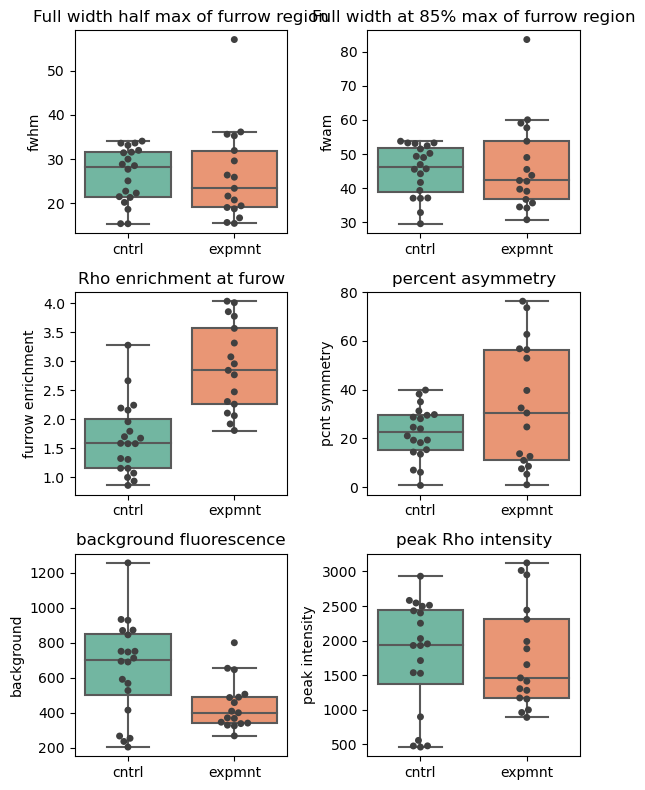

In [6]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(6,8), dpi=100)
swarmBox(df, param='fwhm', axis=ax1)
ax1.set_title('Full width half max of furrow region')
ttest(['cntrl', 'expmnt'], df=df, param='fwhm')
print('###'*10)
swarmBox(df, param='fwam', axis=ax2)
ax2.set_title('Full width at 85% max of furrow region')
ttest(['cntrl', 'expmnt'], df=df, param='fwam')
print('###'*10)
swarmBox(df, param='furrow enrichment', axis=ax3)
ax3.set_title('Rho enrichment at furow')
ttest(['cntrl', 'expmnt'], df=df, param='furrow enrichment')
print('###'*10)
swarmBox(df, param='pcnt symmetry', axis=ax4)
ax4.set_title('percent asymmetry')
ttest(['cntrl', 'expmnt'], df=df, param='pcnt symmetry')
fig.tight_layout()
print('###'*10)
swarmBox(df, param='background', axis=ax5)
ax5.set_title('background fluorescence')
ttest(['cntrl', 'expmnt'], df=df, param='background')
fig.tight_layout()
print('###'*10)
swarmBox(df, param='peak intensity', axis=ax6)
ax6.set_title('peak Rho intensity')
ttest(['cntrl', 'expmnt'], df=df, param='peak intensity')
fig.tight_layout()

## 220329

In [21]:
data_dir = Path('/Volumes/FlashSSD2/220329_Live_Kkpo_Emb_Utr647_Chn1GAP-CAAX_E03-T01/_projection/0_furrow_images/rename/')
images = [file for file in os.listdir(data_dir) if file.endswith('.tif') and not file.startswith('.')]
#images = ['0_22_1104_1812_1353_1530_120_1065_1443_1350_1941_690.tif'] # sample image
plot = False

data = {'file name'     : [],
        'group'         : [],
        'background'    : [],
        'cell length'   : [],
        'pcnt symmetry' : []
        }

for image_name in images:
    furrow = Furrow(image_name)

    pixel_size = 6.4
    magnification = 16
    scale_factor = pixel_size/magnification

    perp_length = math.sqrt( (np.diff(furrow.perp_x))**2 + (np.diff(furrow.perp_y))**2 ) * scale_factor
    perp_midpoint_x, perp_midpoint_y = sum(furrow.perp_x)/2 , sum(furrow.perp_y)/2
    intersection_x, intersection_y = furrow.intersection

    dist_to_mp = math.sqrt((perp_midpoint_x - intersection_x)**2 + (perp_midpoint_y - intersection_y)**2) * scale_factor
    dist_from_end = perp_length / 2
    percent_of_length = (dist_to_mp / dist_from_end) * 100

    data['cell length'].append(perp_length)
    data['pcnt symmetry'].append(percent_of_length)
    data['file name'].append(furrow.file_name)
    data['group'].append(furrow.group)
    data['background'].append(furrow.background)



FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/FlashSSD2/220329_Live_Kkpo_Emb_Utr647_Chn1GAP-CAAX_E03-T01/_projection/0_furrow_images/rename'

In [ ]:
df = pd.DataFrame(data=data)
df

,file name,group,background,cell length,pcnt symmetry
0,0_423_600_1614_594_1782_50_759_1752_75_1650_40...,cntrl,401,276.625378,52.321596
1,0_04338_12_543_426_486_120_120_30_210_951_454.tif,cntrl,454,370.154778,6.735606
2,0_2299_111_777_252_609_50_3_324_393_852_499.tif,cntrl,499,262.567020,17.193930
3,0_2321_273_1818_738_1722_120_534_1383_729_2048...,cntrl,393,277.200289,8.078489
4,0_2364_279_1044_321_1323_50_642_1251_0_1392_45...,cntrl,456,262.920520,0.068093
5,0_4187_186_1125_45_1206_50_21_927_309_1437_447...,cntrl,447,234.279833,13.305613
6,0_5922_165_1653_312_1839_50_111_1824_606_1557_...,cntrl,350,224.967198,46.419025
7,0_7766_474_1359_663_1488_50_450_1557_717_1257_...,cntrl,373,160.643207,11.089168
8,0_7787_345_1845_534_1755_50_264_1623_477_2043_...,cntrl,356,188.369424,0.054795
9,0_7939_267_627_171_789_50_24_576_489_825_670.tif,cntrl,670,210.988530,10.792672


##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.1478187
no significant difference found between groups
##############################


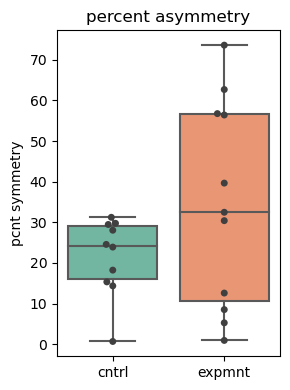

In [ ]:
fig, ax = plt.subplots(figsize=(3,4), dpi=100)
print('###'*10)
swarmBox(df, param='pcnt symmetry', axis=ax)
ax.set_title('percent asymmetry')
ttest(['cntrl', 'expmnt'], df=df, param='pcnt symmetry')
fig.tight_layout()
print('###'*10)

## Combined LEFT OFF HERE

In [7]:
data_dir = Path('/Users/bementmbp/Desktop/asymmetry_combined')
images = [file for file in os.listdir(data_dir) if file.endswith('.tif') and not file.startswith('.')]
#images = ['0_22_1104_1812_1353_1530_120_1065_1443_1350_1941_690.tif'] # sample image
plot = False

data = {'file name'     : [],
        'group'         : [],
        'background'    : [],
        'cell length'   : [],
        'pcnt symmetry' : []
        }

for image_name in images:
    furrow = Furrow(image_name)

    pixel_size = 6.4
    magnification = 16
    scale_factor = pixel_size/magnification

    perp_length = math.sqrt( (np.diff(furrow.perp_x))**2 + (np.diff(furrow.perp_y))**2 ) * scale_factor
    perp_midpoint_x, perp_midpoint_y = sum(furrow.perp_x)/2 , sum(furrow.perp_y)/2
    intersection_x, intersection_y = furrow.intersection

    dist_to_mp = math.sqrt((perp_midpoint_x - intersection_x)**2 + (perp_midpoint_y - intersection_y)**2) * scale_factor
    dist_from_end = perp_length / 2
    percent_of_length = (dist_to_mp / dist_from_end) * 100

    data['cell length'].append(perp_length)
    data['pcnt symmetry'].append(percent_of_length)
    data['file name'].append(furrow.file_name)
    data['group'].append(furrow.group)
    data['background'].append(furrow.background)



In [8]:
df = pd.DataFrame(data=data)

##############################
Calculating T-Test for groups  ['cntrl', 'expmnt']
p value for a T-Test is 0.0278853
##############################


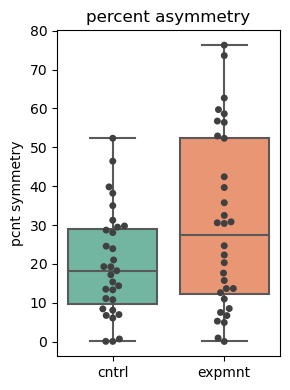

In [9]:
fig, ax = plt.subplots(figsize=(3,4), dpi=100)
print('###'*10)
swarmBox(df, param='pcnt symmetry', axis=ax)
ax.set_title('percent asymmetry')
ttest(['cntrl', 'expmnt'], df=df, param='pcnt symmetry')
fig.tight_layout()
print('###'*10)

In [ ]:
images = ['0_22_1104_1812_1353_1530_120_1065_1443_1350_1941_690.tif']
images = ['0_22_1250_1700_1353_1530_120_1065_1443_1350_1941_690.tif']
image = images[0]
furrow = Furrow(image)

pixel_size = 6.4
magnification = 16
scale_factor = pixel_size/magnification

perp_length = math.sqrt( (np.diff(furrow.perp_x))**2 + (np.diff(furrow.perp_y))**2 ) * scale_factor
perp_midpoint_x, perp_midpoint_y = sum(furrow.perp_x)/2 , sum(furrow.perp_y)/2
intersection_x, intersection_y = furrow.intersection

dist_to_mp = math.sqrt((perp_midpoint_x - intersection_x)**2 + (perp_midpoint_y - intersection_y)**2) * scale_factor
dist_from_end = perp_length / 2
percent_of_length = (dist_to_mp / dist_from_end) * 100



plt.plot(furrow.furrow_x, furrow.furrow_y)
plt.plot(furrow.perp_x, furrow.perp_y)
plt.plot(perp_midpoint_x, perp_midpoint_y, marker='o')
plt.plot(intersection_x, intersection_y, marker='*')
plt.show()



In [ ]:
trace_path = Path('/Users/bementmbp/Desktop/double_peak.rtf')

minPeakProm = 0.25
trace = np.loadtxt(trace_path)
raw = trace[:,1]
smoothed = sig.savgol_filter(raw, window_length=15, polyorder=2)

proms, leftBases, rightBases, widths, heights, leftIndex, rightIndex = find_fwhm(smoothed)

'''
proms = (peak - base) distance
leftBases = x coordinates of left bases of peak
rightBases = x coordinates of right bases of peak
widths = width of fwhm
heights = height of full width half max
leftIndex = interpolated x coordinate of fwhm left side
rightIndex = interpolated x coordinate of fwhm right side
'''

main_peak_index = np.argmax(widths)
width = widths[main_peak_index]
left_background = leftBases[main_peak_index]
right_background = rightBases[main_peak_index]
peak_amplitude = proms[main_peak_index]
fwhm_left = leftIndex[main_peak_index]
fwhm_right = rightIndex[main_peak_index]
fwhm_height = heights[main_peak_index]


fig, ax = plt.subplots()

ax.vlines(x = left_background, ymin = smoothed[left_background], ymax = smoothed[left_background] + peak_amplitude)
ax.vlines(x = right_background, ymin = smoothed[right_background], ymax = smoothed[right_background] + peak_amplitude)
ax.hlines(fwhm_height, fwhm_left, fwhm_right)

ax.plot(raw)
ax.plot(smoothed)
plt.show()
